In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\palla\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
df = pd.read_csv("complaints.csv")
print("Shape:", df.shape)
df.head()


Shape: (11477113, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2020-07-06,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,FL,346XX,NaN,Other,Web,2020-07-06,Closed with explanation,Yes,NaN,3730948
1,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information is missing that should be on the r...,NaN,NaN,"EQUIFAX, INC.",TX,75062,NaN,NaN,Web,2025-10-14,In progress,Yes,NaN,16558024
2,2025-10-10,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",GA,30341,NaN,NaN,Web,2025-10-10,In progress,Yes,NaN,16507707
3,2025-10-15,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,79928,NaN,NaN,Web,2025-10-15,In progress,Yes,NaN,16558548
4,2025-10-14,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Experian Information Solutions Inc.,GA,306XX,NaN,Other,Web,2025-10-14,In progress,Yes,NaN,16583809


In [4]:
df = df[['Product', 'Consumer complaint narrative']].dropna()
df = df.rename(columns={'Consumer complaint narrative': 'complaint'})
df.head()


,Product,complaint
67,"Credit reporting, credit repair services, or o...",These are not my accounts.
87,"Money transfer, virtual currency, or money ser...",On XX/XX/2025 at XXXXXXXX XXXX I contacted XX...
124,Credit reporting or other personal consumer re...,Kindly address this issue on my credit report....
174,Credit reporting or other personal consumer re...,I have never legally gone by these personal in...
181,Debt collection,Your agency placed an unauthorized collection ...


In [5]:
mapping = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}
df = df[df['Product'].isin(mapping.keys())]
df['label'] = df['Product'].map(mapping)
df = df[['complaint', 'label']]
df.head()


,complaint,label
181,Your agency placed an unauthorized collection ...,1
448,"My mortgage servicer, NewRez, failed to pay my...",3
673,"This individual contacted my father, who is in...",1
760,I want to stress that I did not give written p...,1
839,CFPB Complaint False Credit Reporting by Summi...,1


In [6]:
def clean_text(text):
    text = str(text).lower()
    words = [w for w in text.split() if w.isalpha() and w not in STOPWORDS]
    return ' '.join(words)

df['cleaned'] = df['complaint'].apply(clean_text)
df.head()


,complaint,label,cleaned
181,Your agency placed an unauthorized collection ...,1,agency placed unauthorized collection credit f...
448,"My mortgage servicer, NewRez, failed to pay my...",3,mortgage failed pay town property taxes xxxx p...
673,"This individual contacted my father, who is in...",1,individual contacted another disclosed collect...
760,I want to stress that I did not give written p...,1,want stress give written permission specific t...
839,CFPB Complaint False Credit Reporting by Summi...,1,cfpb complaint false credit reporting summit a...


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['label'], test_size=0.2, random_state=42)


In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [9]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred))



Naive Bayes Accuracy: 0.950
              precision    recall  f1-score   support

           1       0.97      0.97      0.97     74191
           2       0.68      0.28      0.40      1807
           3       0.90      0.95      0.92     27068

    accuracy                           0.95    103066
   macro avg       0.85      0.73      0.76    103066
weighted avg       0.95      0.95      0.95    103066


Logistic Regression Accuracy: 0.967
              precision    recall  f1-score   support

           1       0.97      0.98      0.98     74191
           2       0.73      0.47      0.57      1807
           3       0.96      0.96      0.96     27068

    accuracy                           0.97    103066
   macro avg       0.89      0.80      0.83    103066
weighted avg       0.97      0.97      0.97    103066



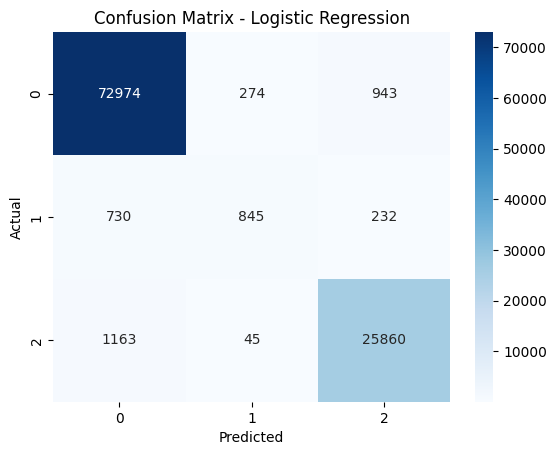

In [10]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
